<a href="https://colab.research.google.com/github/spentaur/DS-Unit-2-Kaggle-Challenge/blob/master/DSPT2_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import scipy.stats as st
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline
import category_encoders as ce
from scipy.stats import uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
sns.set_style("whitegrid")

In [0]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [0]:
# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
target = 'shot_made_flag'

In [5]:
df[target].value_counts(normalize=True)[0]

0.5270812437311936

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
def split():
    df['game_date'] = pd.to_datetime(df['game_date'])

    df['game_date'].describe()

    test = df[df['game_date'] >= '2018-10-01'].copy()
    train = df[df['game_date'] < '2018-10-01'].copy()

    assert len(test) == 1709
    assert len(test) + len(train) == len(df)

    return train, test

In [7]:
train, test = split()
train.shape, test.shape

((12249, 20), (1709, 20))

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
def add_features(data):

    datas = []

    for X in data:
        X = X.copy()

        X['at_home'] = X['htm'] == 'GSW'
        X['opponent'] = [t[0] if t[0] != 'GSW' else t[1] for t in X[['htm', 'vtm']].itertuples(index=False)]
        X['seconds_remaining_in_period'] = (X['minutes_remaining'] * 60) + X['seconds_remaining']
        X['seconds_remaining_in_game'] = ((4 - X['period']) * 12 * 60) + X['seconds_remaining_in_period']
        # X['made_previous_shot']

        datas.append(X)

    return datas

In [0]:
train, test = add_features(split())

In [96]:
train.shape, test.shape

((12249, 24), (1709, 24))

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
def train_val_split(X):
    train = X[X['game_date'] <= '2017-06-30']
    val = X[(X['game_date'] > '2017-07-01') & (X['game_date'] <= '2018-06-30')]

    assert len(train) == 11081
    assert len(val) == 1168

    return train,val

In [0]:
train, val = train_val_split(train)

In [99]:
train.shape, val.shape, test.shape

((11081, 24), (1168, 24), (1709, 24))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
y_test = test[target]

In [101]:
train.dtypes.sort_values()

at_home                                  bool
game_id                                 int64
game_date                      datetime64[ns]
shot_made_flag                          int64
loc_y                                   int64
loc_x                                   int64
seconds_remaining_in_period             int64
shot_distance                           int64
seconds_remaining                       int64
minutes_remaining                       int64
period                                  int64
game_event_id                           int64
seconds_remaining_in_game               int64
scoremargin_before_shot               float64
shot_zone_basic                        object
shot_zone_area                         object
shot_zone_range                        object
action_type                            object
player_name                            object
htm                                    object
vtm                                    object
season_type                       

In [102]:
train.select_dtypes('object').nunique().sort_values()

player_name         1
shot_type           2
season_type         2
shot_zone_range     5
shot_zone_area      6
shot_zone_basic     7
opponent           31
htm                32
vtm                32
action_type        51
dtype: int64

In [103]:
train.select_dtypes('number').nunique().sort_values()

shot_made_flag                    2
period                            6
minutes_remaining                12
seconds_remaining                60
shot_distance                    73
scoremargin_before_shot          79
loc_y                           380
loc_x                           455
game_event_id                   633
game_id                         647
seconds_remaining_in_period     713
seconds_remaining_in_game      2774
dtype: int64

In [119]:
low_card = ['shot_type',
            'season_type',
            'shot_zone_range',
            'shot_zone_area', 
            'shot_zone_basic']

high_card = ['opponent', 'action_type']

numbers = ['seconds_remaining_in_period', 
           'shot_distance',
           'period',
           'loc_y',
           'loc_x',
           'seconds_remaining_in_game',
           'scoremargin_before_shot']

bools = ['at_home']

features = low_card + high_card + numbers + bools

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_card),
    ce.OrdinalEncoder(cols=high_card),
    RandomForestClassifier(random_state=42, n_estimators=100)
)

pipeline.fit(train[features], train[target])

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['shot_type', 'season_type',
                                     'shot_zone_range', 'shot_zone_area',
                                     'shot_zone_basic'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['opponent', 'action_type'],
                                drop_invariant=False, handl...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                 



## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [120]:
pipeline.score(val[features], val[target])

0.601027397260274

## 7. Get your model's test accuracy

> (One time, at the end.)

In [121]:
pipeline.score(test[features], test[target])

0.6167349327091867

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

Thus in binary classification, the count of true negatives is C<sub>0,0</sub> , false negatives is C<sub>1,0</sub> , true positives is C<sub>1,1</sub> and false positives is C<sub>0,1</sub>


In [0]:
c = np.array([[85, 58],[8, 36]])

In [0]:
true_negatives = c[0,0]
false_negatives = c[1,0]
true_positives = c[1,1]
false_positives = c[0,1]

### Calculate accuracy 

In [131]:
(true_negatives + true_positives) / c.sum()

0.6470588235294118

### Calculate precision

In [134]:
true_positives / (true_positives + false_positives)

0.3829787234042553

### Calculate recall

In [135]:
true_positives / (true_positives + false_negatives)

0.8181818181818182

# Stretch

### Make 2+ visualizations to explore relationships between features and target.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


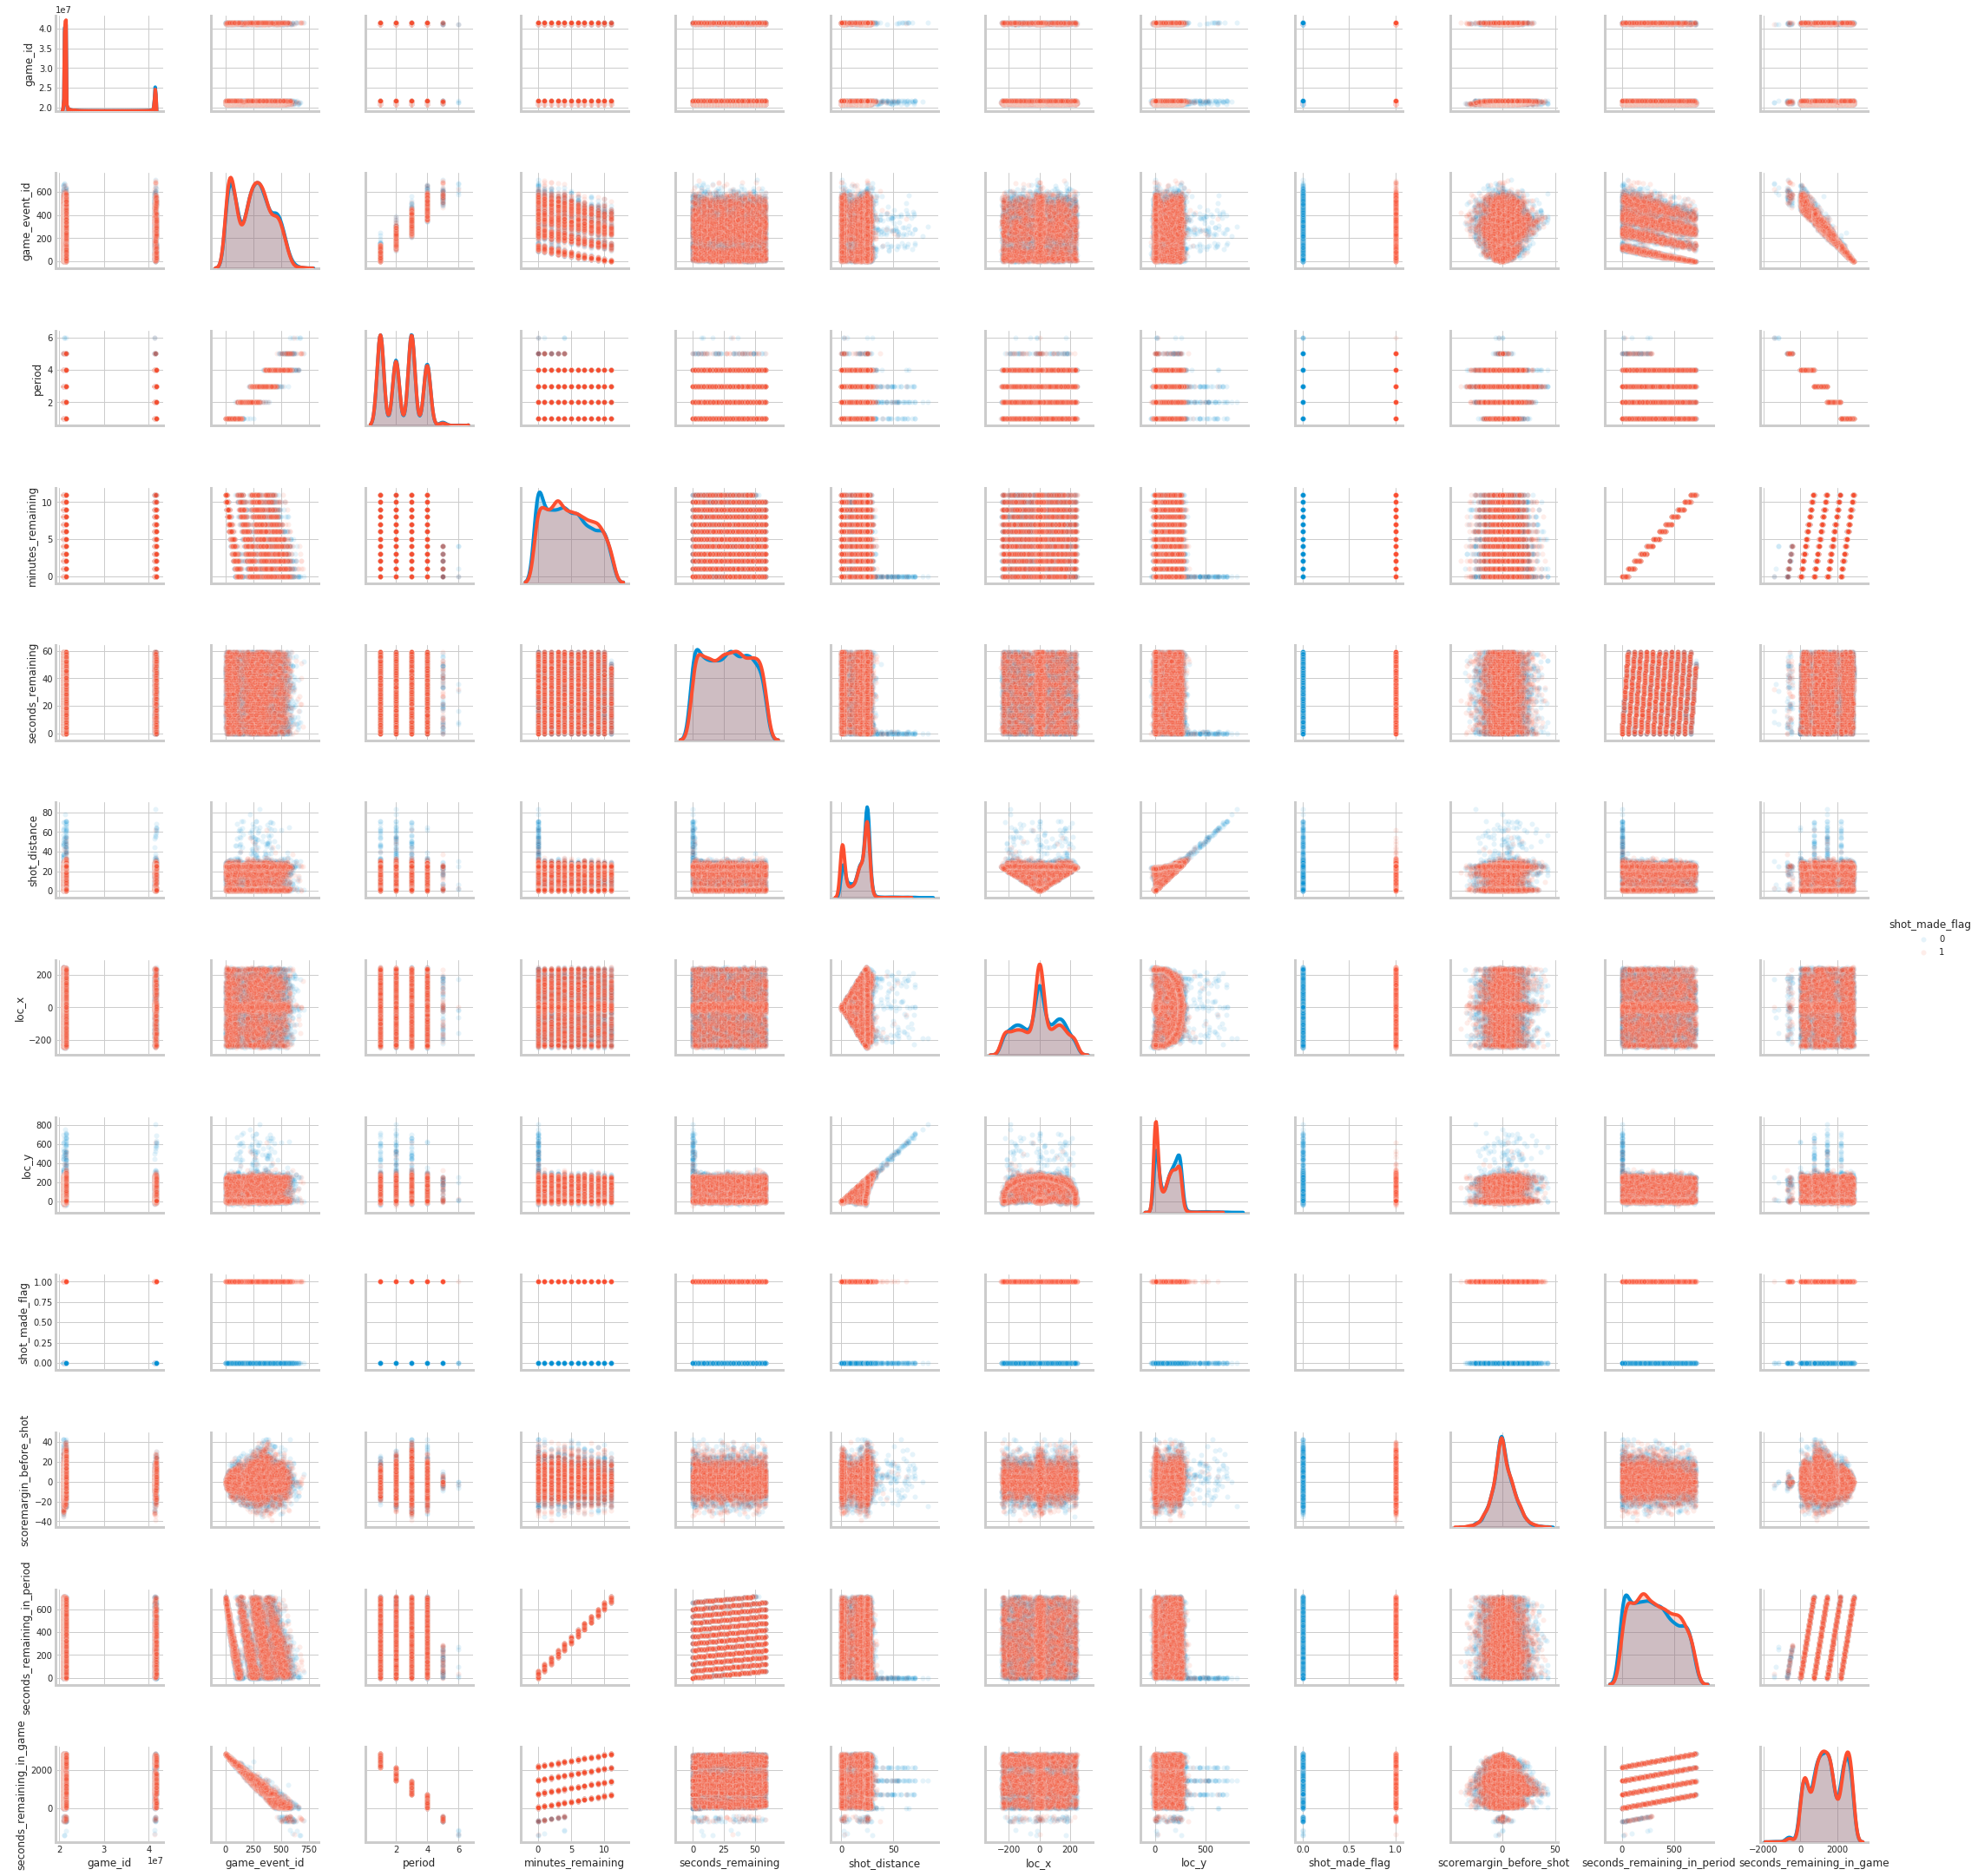

In [137]:
sns.pairplot(train.select_dtypes('number'), hue=target, plot_kws={'alpha': .1})

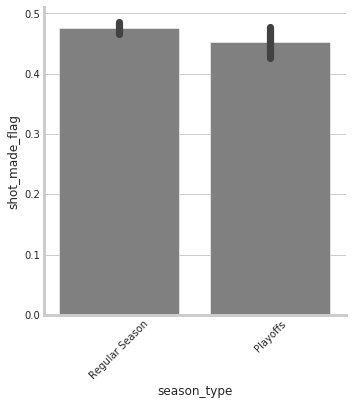

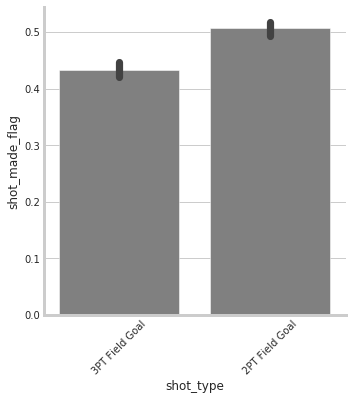

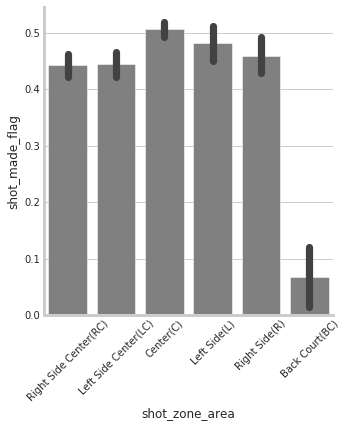

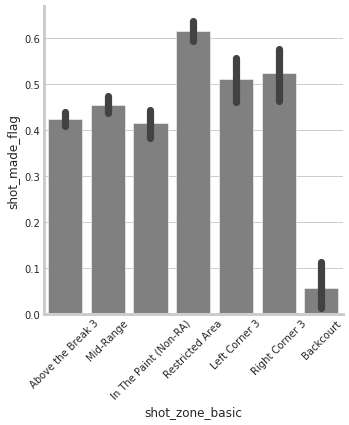

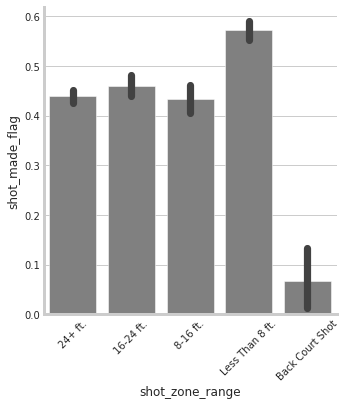

In [138]:
for col in sorted(low_card):
    sns.catplot(x=col, y=target, data=train, kind='bar', color='grey')
    plt.xticks(rotation=45)
    plt.show()

### Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use RandomizedSearchCV or do it manually.

In [198]:
param_dist = {"randomforestclassifier__max_depth": [3, None],
              "randomforestclassifier__max_features": range(1, len(train.columns) + 1),
              "randomforestclassifier__min_samples_split": range(2, 11),
              "randomforestclassifier__bootstrap": [True, False],
              "randomforestclassifier__criterion": ["gini", "entropy"]}

clf = RandomForestClassifier(random_state=42, n_estimators=100)

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_card),
    ce.OrdinalEncoder(cols=high_card),
    clf
)

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    n_jobs=-1)

random_search.fit(train[features], train[target])

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=['shot_type',
                                                                  'season_type',
                                                                  'shot_zone_range',
                                                                  'shot_zone_area',
                                                                  'shot_zone_basic'],
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=False,
      

In [199]:
print('Best hyperparameters', random_search.best_params_)

Best hyperparameters {'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__max_features': 14, 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': True}


In [0]:
best_random = random_search.best_estimator_

In [201]:
best_random.score(val[features], val[target])

0.6095890410958904

In [202]:
best_random.score(test[features], test[target])

0.6179052077238151

### Get and plot your model's feature importances.

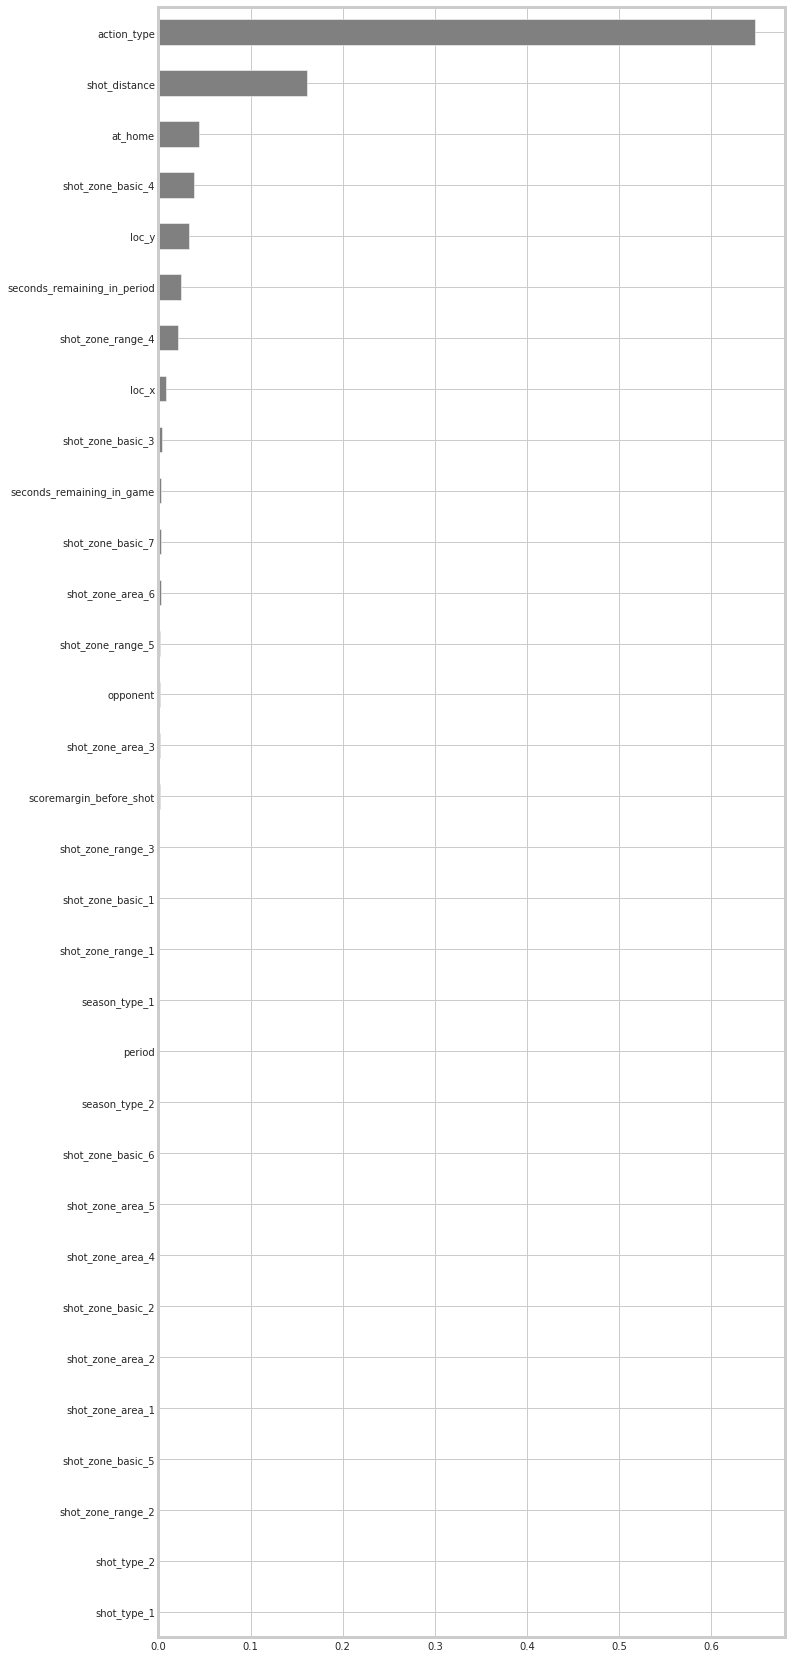

In [205]:
rfc = best_random.named_steps['randomforestclassifier']
ohe = best_random.named_steps['onehotencoder']
oe = best_random.named_steps['ordinalencoder']

ohe_columns = ohe.fit_transform(train[features], low_card)
oe_columns = oe.fit_transform(ohe_columns, high_card)
imp = rfc.feature_importances_

imp = pd.Series(imp, oe_columns.columns)
plt.figure(figsize=(10,30))
imp.sort_values().plot.barh(color='grey');

# im not sure this is exactly right, i'm kinda confused because i used two different encoders,
# so i just don't know if this is the right order of the columns ya know

In [206]:
# select best features from model?

val_encoded = ohe.transform(val[features])
val_encoded = oe.transform(val_encoded)

test_encoded = ohe.transform(test[features])
test_encoded = oe.transform(test_encoded)

selector = SelectFromModel(rfc, threshold=0.2)

X_important = selector.fit_transform(oe_columns, train[target])

val_important = selector.transform(val_encoded)
test_important = selector.transform(test_encoded)

rfc.set_params(max_features = X_important.shape[1])

model = rfc.fit(X_important, train[target])

model.score(val_important, val[target])

0.6018835616438356

In [207]:
model.score(test_important, test[target])

0.6114686951433587